In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/AI
!pip install -r requirements.txt

%cd /content/drive/MyDrive/Colab Notebooks/AI/drawing_diary
pixray_version = "latest release"
branch = "release"
!git clone --recursive --branch $branch https://github.com/pixray/pixray
!pip install -r pixray/requirements.txt
!pip install basicsr
!pip uninstall -y tensorflow 
!git clone https://github.com/pixray/diffvg
%cd diffvg
!git submodule update --init --recursive
!python setup.py install
%cd ..
!pip freeze | grep torch
%cd /content/drive/MyDrive/Colab Notebooks/AI

/content/drive/MyDrive/Colab Notebooks/AI
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.9 MB/s eta 0:09:50tcmalloc: large alloc 1147494400 bytes == 0x3aacc000 @  0x7f11a8ab9615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:24tcmalloc: large alloc 1434370048 bytes == 0x7f122000 @  0x7f11a8ab9615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 7.8 MB/s 
     |████████████████████████████████| 5.8 MB 62.2 MB/s 
     |████████████████████████████████| 190 kB 52.3 MB/s 
  Created wheel for basicsr: filename=basicsr-1.3.5-py3-none-any.whl size=194484 sha256=774a1bd2d240ca610be2ba86c2ef30cdf5575dfbfc00619e52e6f1a6a022c169
  Stored in directory: /root/.cache/pip/wheels/74/1b/d0/8659cf028233dd1e3bf282271009fbf037dfc4ab761f32a032
Successfully built basicsr
Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
fatal: destination path 'diffvg' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/AI/drawing_diary/diffvg
fatal: Needed a single revision
Unable to find current revision in submodule path 'thrust/dependencies/cub'
F

In [3]:
import numpy as np
import itertools
import torch

from konlpy.tag import Okt, Komoran
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from googletrans import Translator
from textrank import KeysentenceSummarizer
from pytorch_lightning.core.lightning import LightningModule
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

In [19]:
doc = """
오늘은 친구들과 생일파티를 했다. 
맛있게 저녁을 먹고, 케이크도 먹었다. 
생일선물로 갖고싶었던 선물도 많이 받았다. 
행복한 하루였다.
"""

In [20]:
classifier = pipeline('zero-shot-classification', model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=0)

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [21]:
out = classifier(doc, ["love", "joy", "surprise", "anger", "sadness", "fear", "neutral", "tired"])
emotion = []

for i in range(8):
  if out['scores'][i]>0.4:
    emotion.append(out['labels'][i])

if len(emotion) == 0:
  emotion.append(out['labels'][0])
  emotion.append(out['labels'][1])

if(len(emotion)>1):
  # 창을 띄워서 사용자가 감정을 선택하는 코드로 바꾸기
  print(emotion)
  emotion_idx = int(input('여러 개의 감정이 느껴지네요! 오늘을 대표하는 감정 1개를 선택해주세요(0, 1, 2, ...의 index로 입력):'))
else:
  emotion_idx = 0

print(emotion[emotion_idx]) # database에 emotion 저장하는 코드 추가하기

EMOTION = emotion[emotion_idx] # database에서 값을 가져오는 코드로 바꾸기
# 감정에 따른 문구 출력
if(EMOTION=='joy'):
  emotion_comment = '오늘은 행복한 하루였군요!'
elif (EMOTION=='love'):
  emotion_comment = '당신의 하루에서 사랑이 느껴지네요.'
elif (EMOTION=='surprise'):
  emotion_comment = '오늘은 놀라운 일이 있었군요.'
elif (EMOTION=='anger'):
  emotion_comment = '오늘은 화가 많이 났던 하루였군요.'
elif (EMOTION=='sadness'):
  emotion_comment = '오늘은 조금 슬픈 하루였군요.'
elif (EMOTION=='fear'):
  emotion_comment = '오늘은 조금 무서웠던 일이 있었군요.'
elif (EMOTION=='neutral'):
  emotion_comment = '당신의 하루에서 평온함이 느껴지네요.'
else:
  emotion_comment = '오늘은 조금 지치는 하루였군요.'

print(emotion_comment)

joy
오늘은 행복한 하루였군요!


In [22]:
okt = Okt()

tokenized_doc = okt.pos(doc)
tokenized_nouns = ' '.join([word[0] for word in tokenized_doc if word[1] == 'Noun'])

In [23]:
n_gram_range = (1,1)

count = CountVectorizer(ngram_range=n_gram_range).fit([tokenized_nouns])
candidates = count.get_feature_names_out()

In [24]:
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

In [25]:
top_n = 5
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [26]:
def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):

    word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding)
    word_similarity = cosine_similarity(candidate_embeddings)
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
    return [words[idx] for idx in keywords_idx]

In [27]:
keyword = mmr(doc_embedding, candidate_embeddings, candidates, top_n=1, diversity=0.4)

In [28]:
translator = Translator()
key = translator.translate(keyword[0], dest='en').text
print(key)

party


In [29]:
komoran = Komoran()
def komoran_tokenizer(sent):
    words = komoran.pos(sent, join=True)
    words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
    return words

summarizer = KeysentenceSummarizer(
    tokenize = komoran_tokenizer,
    min_sim = 0.3,
    verbose = False
)

sents_list = doc.split('.'or '?' or '!')
sents =[]
for sent in sents_list:
    if sent.strip() is not '':
      sents.append(sent.strip())

bias = np.ones(len(sents))
bias[-1] = 5

keysents_list = summarizer.summarize(sents, topk=3, bias=bias)
keysents = []
for _, _, sent in keysents_list:
    keysents.append(sent+'.')

print(keysents)

['맛있게 저녁을 먹고, 케이크도 먹었다.', '행복한 하루였다.', '생일선물로 갖고싶었던 선물도 많이 받았다.']


In [31]:
%cd /content/drive/MyDrive/Colab Notebooks/AI
# KoGPT2 모델에서 사용하는 특수 토큰
U_TKN = '<usr>' # 일기 핵심 문장의 시작을 나타내는 특수 토큰
S_TKN = '<sys>' # 코멘트의 시작을 나타내는 특수 토큰
BOS = '</s>'    # 문장의 시작을 나타내는 특수 토큰
EOS = '</s>'    # 문장의 끝을 나타내는 특수 토큰
UNK = '<unk>'   # 어휘에 없는 토큰을 나타내는 특수 토큰
MASK = '<unused0>'  # 마스킹된 토큰을 나타내는 특수 토큰
SENT = '<unused1>'  # 일기 핵심 문장의 끝을 나타내는 특수 토큰
PAD = '<pad>'   # 토큰 배열을 동일한 크기로 만드는데 사용되는 특수 토큰

# KoGPT2에서 제공하는 토큰나이저 사용
TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token=BOS, eos_token=EOS, unk_token=UNK,
            pad_token=PAD, mask_token=MASK)
class KoGPT2Comment(LightningModule):
    def __init__(self):
        super(KoGPT2Comment, self).__init__()
        self.kogpt2 = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2') # pretrained KoGPT2 model
    def forward(self, inputs):
        # (batch, seq_len, hiddens)
        output = self.kogpt2(inputs, return_dict=True)
        return output.logits
    def comment(self, keysent):
        tok = TOKENIZER
        sent='0'
        sent_tokens = tok.tokenize(sent)
        with torch.no_grad():
                q = keysent
                a = ''
                while 1:
                    input_ids = torch.LongTensor(tok.encode(U_TKN + q + SENT + sent + S_TKN + a)).unsqueeze(dim=0)
                    pred = self(input_ids)
                    gen = tok.convert_ids_to_tokens(
                        torch.argmax(
                            pred,
                            dim=-1).squeeze().numpy().tolist())[-1]
                    if gen == EOS:
                        break
                    a += gen.replace('▁', ' ')
                return a.strip()

model = KoGPT2Comment()
model.load_state_dict(torch.load("model_chp/comment_model.pth"))
model.eval()

moon_comment = ''
max_comment = ''
comment = ''
for sent in keysents:
  comment = model.comment(sent)
  if(comment[-1] is not '?' and (not '.' or not '!')):
        comment = comment + '.'
  if(len(max_comment)<=len(comment)):
        max_comment = comment
  if(len(comment)>8 and '?' not in comment and '저' not in comment):
        moon_comment = comment
        break
if(moon_comment is ''):
  moon_comment = max_comment

print(moon_comment) # database에 moon_comment 저장하는 코드 추가하기


/content/drive/MyDrive/Colab Notebooks/AI


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


오늘도 평안했던 하루에 감사하는 마음을 가져보세요.


In [32]:
%cd /content/drive/MyDrive/Colab Notebooks/AI/drawing_diary/pixray
import sys
sys.path.append("pixray")

# drawing diary image 생성
key = key.replace(' ','_')
!python pixray.py --drawer=line_sketch --prompt=$key --outdir=../output # 그림일기 이미지 저장하는 코드 추가하기

/content/drive/MyDrive/Colab Notebooks/AI/drawing_diary/pixray
Running with 30x1 = 30 cuts
Using seed: 10442160996270004821
Loaded CLIP ViT-B/32: 224x224 and 151.28M params
Loaded CLIP ViT-B/16: 224x224 and 149.62M params
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['party']
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
iter: 0, loss: 1.97, losses: 0.925, 0.0608, 0.925, 0.0622 (-0=>1.973)
iter: 10, loss: 1.86, losses: 0.875, 0.0634, 0.859, 0.0649 (-0=>1.863)
iter: 20, loss: 1.83, losses: 0.861, 0.0647, 0.835, 0.067 (-0=>1.827)
iter: 30, loss: 1.8, losses: 0.846, 0.0672, 0.819, 0.0684 (-0=>1.801)
iter: 40, loss: 1.78, losses: 0.831, 0.0691, 0.

홍길동님,
오늘은 행복한 하루였군요!
오늘도 평안했던 하루에 감사하는 마음을 가져보세요.
제가 홍길동님의 하루를 그림 일기로 표현해봤어요.


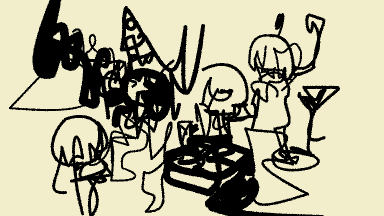

In [33]:
from IPython.display import Image
# AI 분석 페이지 출력 예시
user_name = '홍길동'
print("%s님," % (user_name))
print(emotion_comment)
print(moon_comment)
print("제가 %s님의 하루를 그림 일기로 표현해봤어요." % (user_name))
PATH = '/content/drive/MyDrive/Colab Notebooks/AI/drawing_diary/output/output.png'
Image(PATH) # drawing diary image를 colab에 출력